# Cosmology MCMC notebook!

## Play with data

In [1]:
# Install required packages (if not available on server)

!pip install getdist
#!pip install cobaya
!pip install astroML
!pip install healpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

We will look at Supernova type Ia observations. These supernova are formed from the slow accumulation of mass from a nearby star until it reaches a critical mass of 1.4(?) solar masses, after which it goes supernova at always EXACTLY the same brightness. Therefore, the observed magnitude is only a function of their distance from earth. 

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/).

A detailed example on how to manipulate and plot this data, and estimate H0 can be found here: [https://labcit.ligo.caltech.edu/~ajw/ph4/hubble.py](https://labcit.ligo.caltech.edu/~ajw/ph4/hubble.py).

In [3]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [4]:
# pull out the redshifts (zs), magnitudes (mm) and magnitude estimated errors (dm)
zs = data.T[1]
mm = data.T[2]
dm = data.T[3]

In [5]:
# mm is the "distance modulus" - http://en.wikipedia.org/wiki/Distance_modulus
# from which we can compute the distance in parsecs (pc).
# Note that Numpy allows us to manipulate the whole array at once:
dpc = 10.**(mm/5.+1.)

# and in megaparsecs (Mpc)
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10.**((mm+dm)/5.+1.-6.) - dMpc

<ErrorbarContainer object of 3 artists>

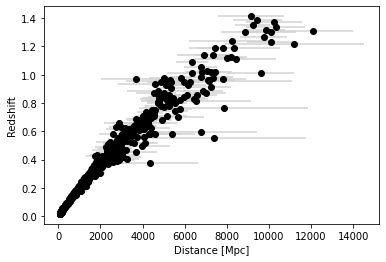

In [6]:
# Plot distance versus redshift
#plt.scatter(dMpc, zs)
# Fancier plot including error bars
plt.xlabel("Distance [Mpc]")
plt.ylabel("Redshift")
plt.errorbar(dMpc, zs, xerr=dMe, fmt='o', color='black', ecolor='lightgray')

## Markov-Chain Monte Carlo
Now let's do some MCMC on some generated data. 

Example is from [https://getdist.readthedocs.io/en/latest/plot_gallery.html](https://getdist.readthedocs.io/en/latest/plot_gallery.html)

In [7]:
from getdist import plots, MCSamples
import getdist

In [8]:
# Generate some 4D distributions with numpy

ndim = 4
nsamp = 10000
np.random.seed(10)

# 4x4 = 16 random from a flat distribution [0,1]
A = np.random.rand(ndim,ndim) 
print("A = ",A)

# Create a covariance matrix
cov = np.dot(A, A.T) 
print("\ncov = ",cov)

# Generate 'ndim'*'nsamp' random values from an 'ndim'-dimensional Gaussian distribution
samps1 = np.random.multivariate_normal([0]*ndim, cov, size=nsamp)
print("\nsamps1 = ",samps1)

# Create a second sample
A = np.random.rand(ndim,ndim)
cov = np.dot(A, A.T)
samps2 = np.random.multivariate_normal([0]*ndim, cov, size=nsamp)

A =  [[0.77132064 0.02075195 0.63364823 0.74880388]
 [0.49850701 0.22479665 0.19806286 0.76053071]
 [0.16911084 0.08833981 0.68535982 0.95339335]
 [0.00394827 0.51219226 0.81262096 0.61252607]]

cov =  [[1.55758352 1.08416425 1.28045358 0.9872521 ]
 [1.08416425 0.91667864 0.96499068 0.74390226]
 [1.28045358 0.96499068 1.41507935 1.1868307 ]
 [0.9872521  0.74390226 1.1868307  1.29789751]]

samps1 =  [[ 1.48141289  1.23465036  0.88360192  0.48051532]
 [ 1.04325096  1.25792555  1.66063953  0.84389961]
 [ 1.66639956  1.61887132  1.9537865   3.22328662]
 ...
 [ 0.35218584  0.14119053  0.51863005  0.68278144]
 [-2.28800058 -1.52156672 -2.45754794 -2.66126869]
 [-1.24684724 -0.45358785 -0.96451894 -0.93341712]]


In [9]:
# Create the GetDist 'MCSamples' objects:
# See https://getdist.readthedocs.io/en/latest/mcsamples.html 

names    = ["x%s"%i for i in range(ndim)]
labels   = ["x_%s"%i for i in range(ndim)]
samples1 = MCSamples(samples=samps1, names = names, labels = labels, label='First set')
samples2 = MCSamples(samples=samps2, names = names, labels = labels, label='Second set')

Removed no burn in
Removed no burn in


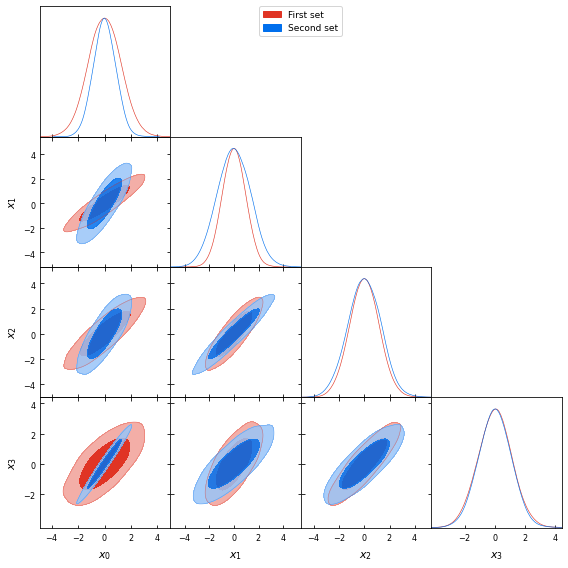

In [10]:
# Triangle plots

g = plots.get_subplot_plotter()
g.triangle_plot([samples1, samples2], filled=True)

In [12]:
# Principle Component Analysis

print(samples1.PCA(['x1','x2']))

PCA for parameters:
         2 :x_1
         3 :x_2

Correlation matrix for reduced parameters
          x1 :  1.0000  0.8487
          x2 :  0.8487  1.0000

e-values of correlation matrix
PC 1:   0.1513
PC 2:   1.8487

e-vectors
  2: -0.7071  0.7071
  3:  0.7071  0.7071

Principle components
PC1 (e-value: 0.151292)
[0.958949]   (x_1-0.004343)/1.000000)
[-0.958949]   (x_2-0.000594)/-1.229803)
          = -0.000000 +- 0.527496

PC2 (e-value: 1.848708)
[1.179318]   (x_1-0.004343)/0.813139)
[1.179318]   (x_2-0.000594)/1.000000)
          = -0.000000 +- 2.267672

Correlations of principle components
       1       2
PC 1   1.000   0.000
PC 2   0.000   1.000
   1   0.077   0.921   (x_0)
   2   0.275   0.961   (x_1)
   3  -0.275   0.961   (x_2)
   4  -0.353   0.807   (x_3)



## Cosmic Microwave Background

Looking at WMAP data using [astroML](https://www.astroml.org/index.html)

In [13]:
import healpy as hp
from astroML.datasets import fetch_wmap_temperatures

In [14]:
# Fetch the wmap data from the NASA website

wmap_unmasked = fetch_wmap_temperatures(masked=False)
wmap_masked   = fetch_wmap_temperatures(masked=True)

# Generate some white noise for comparison
white_noise   = np.ma.asarray(np.random.normal(0, 0.062, wmap_masked.shape))

/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:428: UserWarni

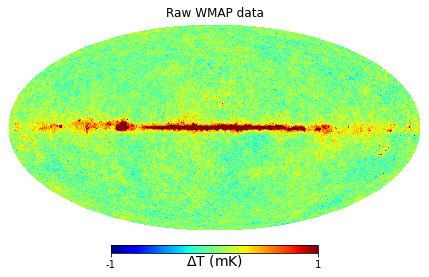

In [15]:
# plot the unmasked map

fig = plt.figure(1)
hp.mollview(wmap_unmasked, min=-1, max=1, title='Raw WMAP data',
            fig=1, cmap=plt.cm.jet, unit=r'$\Delta$T (mK)')
plt.show()

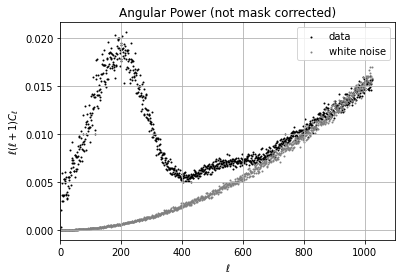

In [16]:
# compute and plot the power spectrum

cl = hp.anafast(wmap_masked.filled(), lmax=1024)
ell = np.arange(len(cl))

cl_white = hp.anafast(white_noise, lmax=1024)

fig = plt.figure(3)
ax = fig.add_subplot(111)
ax.scatter(ell, ell * (ell + 1) * cl,
           s=4, c='black', lw=0,
           label='data')
ax.scatter(ell, ell * (ell + 1) * cl_white,
           s=4, c='gray', lw=0,
           label='white noise')

ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell$')
ax.set_title('Angular Power (not mask corrected)')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlim(0, 1100)

plt.show()